## Compute monthly mean sea-ice concentration anomaly from EUMETSAT OSI SAF data

We compute monthly mean anomaly from EUMETSAT OSI SAF SIC CDR v3 data. This uses xarray.

**NB :** This software is for demonstration purpose only, it is not finalized for production.

In [16]:
import os
import xarray as xr

from datetime import date, datetime, timedelta, time
from dateutil import rrule, relativedelta

import json
import uuid
from copy import copy
import numpy as np

## Configure the run and load data

In [17]:
dt = date(2024,12,12)
area = 'nh'
climodir = '.'
outdir = '.'
indirs = 'osisaf_sic_cdr_storeB.json'

# climo : years for the climatology. **Both ends are included**.
climo = (1991, 2000)

In [18]:
# find the climatology file
climof = os.path.join(climodir,'./ice_conc_{}_ease2-250_climatology-v3p0_{}-{}.nc'.format(area, str(climo[0]), str(climo[1])))
climo_ds = xr.open_dataset(climof)
climo_dso = xr.open_dataset(climof, mask_and_scale=False, decode_times=False) 

In [24]:
# input monthly SIC files
fn_patt = 'ice_conc_{a:}_ease2-250_{c:}_{d:%Y%m}.nc'
fn_patt_src = {'cdr': 'cdr-v3p0', 'icdr': 'icdr-v3p0', 'icdrft': 'icdrft-v3p0'}

if indirs is None:
    inpdir_cdr = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/'
    inpdir_icdr = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/monthly/'
    # access through THREDDS/OpenDAP
    sources = {'cdr':inpdir_cdr,
              'icdr':inpdir_icdr,
              'icdrft':inpdir_icdr}
    jsond = json.dumps(sources, sort_keys=True, indent=4)
else:
    # load json file with path to input directories (if the daily SIC files are downloaded to a local disk)
    # an example json file (prepare_monthly_osisaf_sic_opendap.json) is provided to demonstrate the format
    #   expected for the json file (but the effect will be the same as setting indirs to None: read from
    #   THREDDS/opendap)
    with open(indirs, 'r') as f:
        sources = json.load(f)
        for s in sources.keys():
            sources[s] += '/monthly/'

In [25]:
def find_one_monthly_sic_file(dt, area):
    
    found_one_file = False
    for cdr in ('cdr', 'icdr', 'icdrft'):
        fn = fn_patt.format(a=area, d=dt, c=fn_patt_src[cdr])
        fn = os.path.join(sources[cdr],'{:%Y/}'.format(dt),fn)
        try:
            # this url exists, append it and move to next date
            ds = xr.open_dataset(fn)
            found_one_file = True
            return fn, cdr
        except OSError:
            # no valid file at this url, check the next rule
            # print("Failed with pattern {}".format(fn))
            pass
        
    # no file found. Add a warning (but we can continue)
    if not found_one_file:
        print("WARNING: could not find OSI SAF SIC v3 file for {} {}".format(area, dt))
        return None, None



## Compute anomaly

In [26]:
# A routine to reconstruct the unfiltered, unthresholded SICs from a OSI SAF SIC CDR file
def reconstruct_sic(ds):
    ice_conc = ds['ice_conc'].to_masked_array()
    raw_ice_conc_values = ds['raw_ice_conc_values'].to_masked_array()
    status_flag = ds['status_flag'].to_masked_array().astype('short')
    
    # combine ice_conc with raw_ice_conc_values using the status_flag
    new_ice_conc = copy(ice_conc)
    raw_100_mask = np.array((ice_conc==100) * (~raw_ice_conc_values.mask))
    new_ice_conc[raw_100_mask] = raw_ice_conc_values[raw_100_mask]
    
    new_ice_conc[(status_flag & 4) == 4] = raw_ice_conc_values[(status_flag & 4) == 4]

    # re-enter "full" ice_conc into the xarray dataset
    ds['ice_conc'][:] = new_ice_conc
    return ds

In [27]:
fn, src = find_one_monthly_sic_file(dt, area)

if fn is None:
    raise ValueError("Found no file for target month.")

print(fn)

# read monthly mean field
month_ds = xr.open_dataset(fn, engine='netcdf4')
month_ds = reconstruct_sic(month_ds)

# also open the monthly file without CF-decoding to extract information like dtype, _FillValue, time units, etc...
dso = xr.open_dataset(fn, mask_and_scale=False, decode_times=False)

/lustre/storeB/project/copernicus/osisaf/data/reprocessed/ice/conc-cont-reproc/v3p0//monthly/2024/ice_conc_nh_ease2-250_icdr-v3p0_202412.nc


In [28]:
# it is an error to mix time units between the monthly mean and the climatology
if dso['time'].attrs['units'] != climo_dso['time'].attrs['units']:
    raise ValueError("The time units of the monthly and climatology files differ. This is going to be an issue.")

In [29]:
# transfer xc and yc bounds from the climatology file
#   (these should be in the monthly file)
for ac in ('xc', 'yc'):
    acbnds = ac + '_bnds'
    month_ds[acbnds] = climo_ds[acbnds]
    month_ds[ac].attrs['bounds'] = acbnds

In [30]:
# compute anomaly against climatology
month_climato = climo_ds['ice_conc_mean'].isel(time=dt.month-1)
month_ds['ice_conc_anomaly'] = month_ds['ice_conc'] - month_climato

# adjust attributes
climo_n = 'climatological_time'
month_ds['ice_conc_anomaly'].attrs['standard_name'] = 'sea_ice_area_fraction_anomaly'
month_ds['ice_conc_anomaly'].attrs['long_name'] = 'Anomaly of monthly mean sea-ice concentration'
month_ds['ice_conc_anomaly'].attrs['grid_mapping'] = 'Lambert_Azimuthal_Grid'
month_ds['ice_conc_anomaly'].attrs['coordinates'] = climo_n + ' lat lon'
month_ds['ice_conc_anomaly'].attrs['cell_methods'] = "time: mean"
month_ds['ice_conc_anomaly'].attrs['comment'] = 'This is the anomaly for mean {:%B %Y} wrt the climatological mean of {:%B} {}-{}'.format(dt, dt,
                                                                                str(climo[0]), str(climo[1]))

# add the climatological_time variable and its bounds
climo_nb = climo_n + '_bnds'
month_ds[climo_n] = xr.DataArray(climo_ds['time'][dt.month-1].values)
month_ds[climo_n].attrs['standard_name'] = 'reference_epoch'
month_ds[climo_n].attrs['bounds'] = climo_nb

month_ds[climo_nb] = xr.DataArray(climo_ds['climatology_bnds'][dt.month-1,:].values, dims=['nv',])

print(month_ds[climo_n])
print(month_ds[climo_nb].values)

<xarray.DataArray 'climatological_time' ()> Size: 8B
array('1996-12-16T00:00:00.000000000', dtype='datetime64[ns]')
Attributes:
    standard_name:  reference_epoch
    bounds:         climatological_time_bnds
['1991-12-01T00:00:00.000000000' '2001-01-01T00:00:00.000000000']


## Write to netCDF/CF

In [31]:
# clean the data structure
month_ds = month_ds.drop_vars(('ice_conc', 'raw_ice_conc_values', 'status_flag'))

# udpate some attributes
now = datetime.utcnow().replace(microsecond=0)
month_ds.attrs['history'] = now.isoformat()+'Z' + ' creation'
month_ds.attrs['date_created'] = now.date().isoformat()

month_ds.attrs['tracking_id'] = str(uuid.uuid4())
month_ds.attrs['product_status'] = 'under development'

# clean some attributes
del month_ds.attrs['doi']
del month_ds.attrs['naming_authority']
del month_ds.attrs['product_id']
del month_ds.attrs['product_name']
del month_ds.attrs['algorithm']

print(month_ds)

<xarray.Dataset> Size: 3MB
Dimensions:                   (time: 1, xc: 432, yc: 432, nv: 2)
Coordinates:
  * time                      (time) datetime64[ns] 8B 2024-12-16T12:00:00
  * xc                        (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                        (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lat                       (yc, xc) float32 746kB ...
    lon                       (yc, xc) float32 746kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid    int32 4B ...
    time_bnds                 (time, nv) datetime64[ns] 16B ...
    xc_bnds                   (xc, nv) float64 7kB ...
    yc_bnds                   (yc, nv) float64 7kB ...
    ice_conc_anomaly          (time, yc, xc) float64 1MB 0.0 0.0 0.0 ... nan nan
    climatological_time       datetime64[ns] 8B 1996-12-16
    climatological_time_bnds  (nv) datetime64[ns] 16B 1991-12-01 2001-01-01
Attributes: (12/38)
    title:                     Monthly Interim Sea Ice Con

In [35]:
# encoding
encoding = {'time': {'dtype':dso['time'].dtype, 'units':dso['time'].units, 'calendar':dso['time'].calendar,'_FillValue':None},
            'time_bnds': {'dtype':dso['time'].dtype, 'units':dso['time'].units, 'calendar':dso['time'].calendar, '_FillValue':None},
             climo_n: {'dtype':dso['time'].dtype, 'units':dso['time'].units, 'calendar':dso['time'].calendar, '_FillValue':None},
             climo_nb: {'dtype':dso['time'].dtype, 'units':dso['time'].units, 'calendar':dso['time'].calendar, '_FillValue':None},
            'lat': {'_FillValue':None}, 'lon': {'_FillValue':None},
            'xc': {'_FillValue':None}, 'yc': {'_FillValue':None},
            'xc_bnds': {'_FillValue':None}, 'yc_bnds': {'_FillValue':None},
            'Lambert_Azimuthal_Grid': {'_FillValue':None, 'dtype':dso['Lambert_Azimuthal_Grid'].dtype}
           }
_vars = []
for v in month_ds.variables:
    if v.startswith('ice_conc_'):
        encoding[v] = {'dtype':np.float32, '_FillValue':np.float32(-999.)}
        _vars.append(v)

# reorder the variables in the dataset before writing to disk.
ordered_variables = ['Lambert_Azimuthal_Grid', 'time', 'time_bnds', climo_n, climo_nb, 
                     'xc', 'yc', 'xc_bnds', 'yc_bnds', 'lat', 'lon',] + _vars
if len(ordered_variables) != len(month_ds.variables):
    raise ValueError("Missing some variables!")

month_ds_2 = xr.Dataset({var_name: month_ds[var_name] for var_name in ordered_variables}, attrs=month_ds.attrs)
print(month_ds_2)

print()
print(month_ds_2['time'])
print()
print(month_ds_2['time_bnds'])
print()
print(month_ds_2[climo_n])
print()
print(month_ds_2[climo_nb])

print(encoding)

<xarray.Dataset> Size: 3MB
Dimensions:                   (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                      (time) datetime64[ns] 8B 2024-12-16T12:00:00
  * xc                        (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                        (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lon                       (yc, xc) float32 746kB -135.0 -135.1 ... 45.0
    lat                       (yc, xc) float32 746kB 16.62 16.82 ... 16.82 16.62
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid    int32 4B ...
    time_bnds                 (time, nv) datetime64[ns] 16B ...
    climatological_time       datetime64[ns] 8B 1996-12-16
    climatological_time_bnds  (nv) datetime64[ns] 16B 1991-12-01 2001-01-01
    xc_bnds                   (xc, nv) float64 7kB ...
    yc_bnds                   (yc, nv) float64 7kB ...
    ice_conc_anomaly          (time, yc, xc) float64 1MB 0.0 0.0 0.0 ... nan nan
Attributes: (12/38)
    title:     

In [33]:
# write to netCDF/CF

## Note : this filename is still just a proposal
outname = './ice_conc_{}_ease2-250_anomaly-v3p0_{:%Y%m}_{}-{}.nc'.format(area, dt, climo[0], climo[1])

month_ds_2.to_netcdf(outname, encoding=encoding)

print(outname, "is ready.")

./ice_conc_nh_ease2-250_anomaly-v3p0_202412_1991-2000.nc is ready.


## Visualization 

KeyError: "No variable named 'ice_conc'. Variables on the dataset include ['time', 'Lambert_Azimuthal_Grid', 'xc', 'yc', 'time_bnds', ..., 'xc_bnds', 'yc_bnds', 'ice_conc_anomaly', 'climatological_time', 'climatological_time_bnds']"

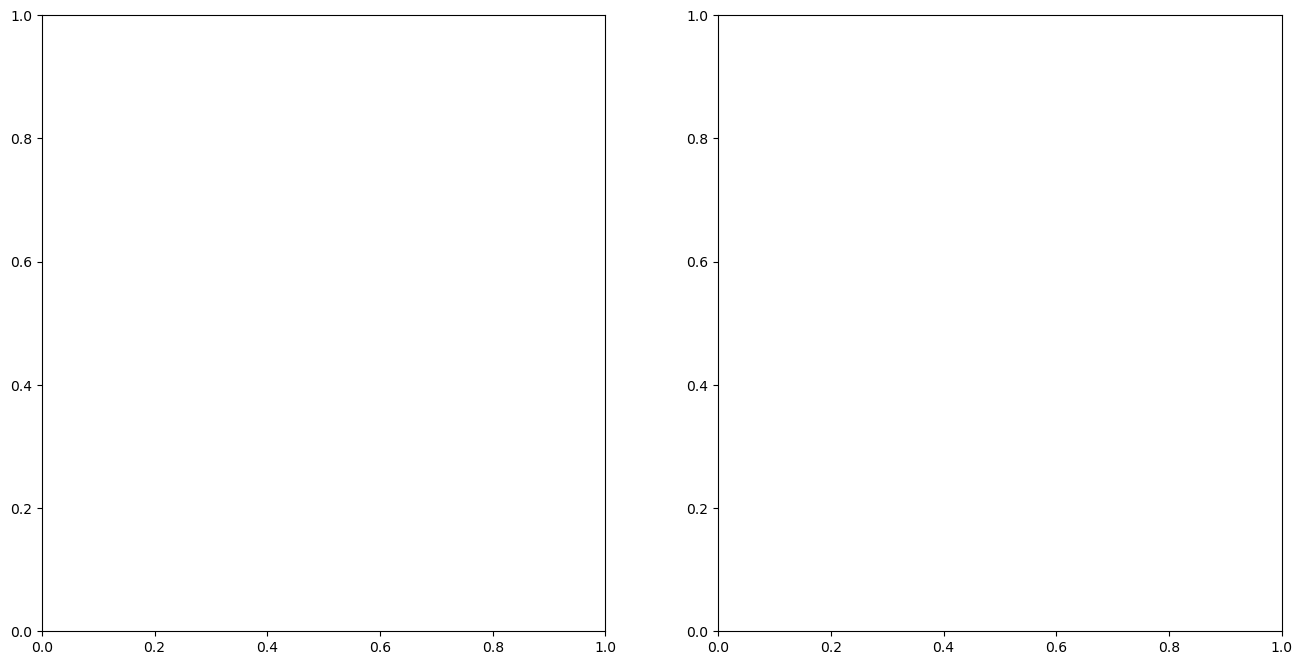

In [14]:
from matplotlib import pylab as plt
from cmocean import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cmap = copy(plt.colormaps['PuBu_r'])
cmap.set_bad('grey')

fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(16,8))

# Monthly mean SIC + median climatological ice edge
cols = ax.imshow(month_ds['ice_conc'][0].to_masked_array(),
          interpolation='none', vmin=0, vmax=100, cmap=cmap)
ax.contour(climo_ds['ice_conc_median'].isel(time=dt.month-1).to_masked_array(), levels=(15.,), colors='coral',)

ax.set_xticks([])
ax.set_yticks([])
ax.text(0.01,0.99,'Monthly Mean SIC {:%B %Y}'.format(dt,), va='top', transform=ax.transAxes, color='white')
ax.text(0.01,0.95,'{d:%B} {c1:}-{c2:} Median Edge'.format(d=dt, c1=str(climo[0]), c2=str(climo[1])),
        va='top', transform=ax.transAxes, color='coral')
ax.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI', rotation=90, ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12, va='bottom', transform=ax.transAxes, color='white')

cbaxes = inset_axes(ax, width="32%", height="3%", loc=3, borderpad=0,
                    bbox_to_anchor=(0.06, 0.1, 1, 1),
                    bbox_transform=ax.transAxes)
cbar = plt.colorbar(cols, cax=cbaxes, orientation="horizontal",)
cbar.ax.set_title('Sea Ice Concentration [%]',fontsize=8,color='w')
cbar.ax.tick_params(labelsize=9,colors='w')

# Monthly anomaly
cmap = copy(cm.balance_r)
cmap.set_bad('grey')

cols = ax1.imshow(month_ds['ice_conc_anom'][0].to_masked_array(),
          interpolation='none', vmin=-100, vmax=100, cmap=cmap)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.text(0.01,0.99,'Anomaly {:%B %Y} wrt {}-{}'.format(dt, *climo), va='top', transform=ax1.transAxes)
ax1.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI', rotation=90, ha='left', va='bottom', transform=ax1.transAxes)
ax1.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12, va='bottom', transform=ax1.transAxes, color='k')

cbaxes = inset_axes(ax1, width="32%", height="3%", loc=3, borderpad=0,
                    bbox_to_anchor=(0.06, 0.1, 1, 1),
                    bbox_transform=ax1.transAxes)
cbar = plt.colorbar(cols, cax=cbaxes, orientation="horizontal",)
cbar.ax.set_title('Anomaly [%]',fontsize=8,color='k')
cbar.ax.tick_params(labelsize=9,colors='k')

plt.show()